In [1]:
import ephem
import numpy as np
from datetime import datetime
from astropy.time import Time
import pandas as pd
import math

In [2]:
 def data():
        def set_axis(df):
            values = ["year", "month", "conjuction_date", "conjunction_time",  
                      "f", "weekday", "month_name", "day", "sunset_time",  
                      "sun_azimuth", "moon_age", "moon_altitude", "moon_azimuth", "daz",  
                      "magnitude", "elongation", "moonset_time", "lag_time", "best_time", "criterion"]
    
            df.set_axis(values, axis='columns', inplace=True)
            return df      
        def illum(a):#converting elongation to illumination
            val = 50*(1-math.cos(math.radians(a)))
            val = round(val, 1)
            return val
        try:
            df = pd.read_fwf('D:\Moon\code\Karachi.txt')
#             df = pd.read_fwf(args[0]+'\\'+args[1])
        except:
            print("")
        else: 
            df = set_axis(df)
            dfa = df.drop(['f', 'magnitude', 'weekday'], axis=1)
            dfs = dfa.loc[:, :'conjunction_time']
            dfd = dfa.loc[:, 'month_name':'criterion']
            dfd.fillna(method='bfill', inplace=True)
            dfs.fillna(method='ffill', inplace=True)

            # Combining dfs
            dfg = dfs.combine_first(dfd)
            dfg.drop_duplicates(inplace=True)
            dfg.dropna(inplace=True)

            # Set correct formats
            liste = ['conjunction_time', 'sunset_time', 'moonset_time', 'best_time']
            for x in liste:
                dfg[x] = dfg[x].replace(' ', ':', regex=True)

            listf = ['conjuction_date', 'day', 'year', 'lag_time', 'moon_altitude', 'sun_azimuth', 'daz', 'moon_azimuth']
            for x in listf:
                dfg[x] = (dfg[x].astype(int)).astype(str)

            dfg['month_name'] = dfg['month_name'].str[:3]
            dfg['month'] = dfg['month'].str[:3]
            dfg['date'] = dfg['day'] + dfg['month_name'] + dfg['year']
            dfg['date'] = pd.to_datetime(dfg['date'], format='%d%b%Y')
            dfg = dfg.set_index('date')

            # Create conjunction time column 
            dfg['conjunction_time'] = dfg['conjuction_date'] + dfg['month'] + dfg['year'] + ' ' + dfg['conjunction_time']
            dfg['conjunction_time'] = pd.to_datetime(dfg['conjunction_time'])



            # Illumination calculation in func-->illum using Elongation 
            dfg['elongation'] = dfg['elongation'].astype(int)
            dfg['illumination'] = dfg.apply(lambda row: illum(row['elongation']), axis=1)

            return dfg  # Load data

In [3]:
def process_moon_data(df, lat, lon, elevation=0, pressure=1013.25, horizon='-0:34', epoch='2000'):
    """Iterate through DataFrame and run get_moon_parameters for each date."""
    results = []
    
    for date in df.index:
        datetime = get_sunset_time(lat,lon, date)
        moon_params = get_moon_parameters(datetime, lat, lon, elevation, pressure, horizon, epoch)
        moon_params['date'] = date  # Add date to the results
        results.append(moon_params)
    pd
    return pd.DataFrame(results).set_index('date') # Convert list of dicts to DataFrame
# print(process_moon_data(data(),25, 67, elevation=10, pressure=0, horizon='0', epoch='2000'))


In [4]:
def get_sunset_time(lat, lon, date):
    """Calculate the sunset time for a given location and date."""
    observer = ephem.Observer()
    observer.lat = str(lat)
    observer.lon = str(lon)
    observer.date = date  # Direct datetime assignment

    sun = ephem.Sun()
    
    try:
        sunset_time = observer.next_setting(sun).datetime()
        return sunset_time
    except ephem.AlwaysUpError:
        return "Sun always up"
    except ephem.NeverUpError:
        return "Sun never rises"

In [27]:
def get_moon_parameters(obs_date, lat, lon, elevation=0, pressure=1013.25, horizon='-0:34', epoch='2000'):
    """Calculate Moon and Sun parameters using PyEphem."""
    observer = ephem.Observer()
    observer.lat = str(lat)
    observer.lon = str(lon)
    observer.elev = elevation  # Elevation in meters
    observer.pressure = pressure  # Atmospheric pressure in millibars
    observer.horizon = horizon  # Default horizon accounting for refraction
    observer.epoch = epoch  # Reference epoch for calculations
#     observer.date = obs_date.datetime  # Direct datetime assignment
    observer.date = obs_date

    
    # Ensure date is in UTC format and properly assigned
#     observer.date = ephem.Date(obs_date)  # Convert to Ephem Date format
    
    moon = ephem.Moon()
    sun = ephem.Sun()
    
    # Compute positions for the observer's location
    moon.compute(observer)
    sun.compute(observer)
    
    # Convert values from radians to degrees
    moon_phase = moon.phase  # Percentage of moon illuminated
    moon_alt = np.degrees(float(moon.alt))  # Convert altitude from radians to degrees
    moon_az = np.degrees(float(moon.az))  # Convert azimuth from radians to degrees
    sun_alt = np.degrees(float(sun.alt))  # Convert altitude from radians to degrees
    sun_az = np.degrees(float(sun.az))  # Convert azimuth from radians to degrees
    
    arcv = moon_alt - sun_alt  # Geocentric altitude difference
    moon_illum = moon_phase  # Same as phase in percentage
    moon_ang_diam = moon.size / 60.0  # Convert arcseconds to arcminutes
    moon_dist = moon.earth_distance  # Distance in AU
    elongation = np.degrees(ephem.separation(moon, sun))  # Moon-Sun elongation in degrees
    print(elongation)
    daz = sun_az - moon_az  # Ensures DAZ is between 0° and 180°

    
    # Compute ARCL (Arc of Light)
    arcl = elongation  # In degrees, as per Yallop's definition
       
   # Compute SD' using SD' = SD * (1 + sin h * sin π)
    parallax = np.arcsin(6378.1 / (moon_dist * 149597870.7))  # Earth's radius / Moon distance in km
    sd = 0.27245 * np.sin(parallax)  # Semi-diameter in arcminutes
    parallax = np.arcsin(6378.1 / (moon_dist * 149597870.7))  # Earth's radius / Moon distance in km
    sd_prime = sd * (1 + np.sin(np.radians(moon_alt)) * np.sin(parallax))
    
      # Compute W (Crescent Width) using W = SD' * (1 - cos(ARCL))
    w = sd_prime * (1 - np.cos(np.radians(arcl)))
    
    
    try:
        sunset = observer.next_setting(sun).datetime().strftime('%Y/%m/%d %H:%M:%S')
    except ephem.AlwaysUpError:
        sunset = "Sun always up"
    except ephem.NeverUpError:
        sunset = "Sun never rises"
    
    try:
        moonset = observer.next_setting(moon).datetime().strftime('%Y/%m/%d %H:%M:%S')
    except ephem.AlwaysUpError:
        moonset = "Moon always up"
    except ephem.NeverUpError:
        moonset = "Moon never rises"
    
    return {
        "moon_altitude": moon_alt,
        "moon_azimuth": moon_az,
        "sun_altitude": sun_alt,
        "sun_azimuth": sun_az,
        "arcv": arcv,
        "arcl": arcl,
        "crescent_width": w,
        "moon_phase": moon_phase,
        "moon_illumination": moon_illum,
        "moon_angular_diameter": moon_ang_diam,
        "moon_distance_au": moon_dist,
        "daz": daz,
        "elongation": elongation,
        "sunset_time": sunset,
        "moonset_time": moonset
    }



In [6]:
def calculate_q_and_visibility(moon_params):
    """Calculate q value and determine crescent visibility criteria."""
    arcv = moon_params["arcv"]  # Use altitude difference
    w = moon_params["crescent_width"] * 60  # Convert to arcseconds
    
    q = (arcv - (11.8371 - 6.3226 * w + 0.7319 * w**2 - 0.1018 * w**3)) / 10
    
    if q > 0.216:
        visibility = "A"
    elif 0.216 >= q > -0.014:
        visibility = "B"
    elif -0.014 >= q > -0.160:
        visibility = "C"
    elif -0.160 >= q > -0.232:
        visibility = "D"
    elif -0.232 >= q > -0.293:
        visibility = "E"
    else:
        visibility = "F"
    
    return {"q_value": round(q,2), "visibility_criterion": visibility}

10.180902292918418
23.557868879904923
5.255157573528843
17.15718065608681
10.57829414246664
23.587508405479134
4.202688081967468
16.80885103244258
10.601107223368953
5.510457010093161
15.79917861407108
9.50479249951644
19.842491608186638
4.047045955508522
12.68670968801004
5.159153256381977
15.955207684354482
8.600923988305903
20.277344343182477
3.198307812178248
13.765133048764849
26.09620306575116
8.096803770958392
20.218598795633405
5.308391738397551
14.369035887328495
8.433907531026016
21.90120941935606
2.6766252564260626
15.979914170928888
10.435969423582995
24.255667311886214
5.929833400477786
18.77740970588464
4.1816097095155325
13.52981047606505
8.248098990588277
19.27855987458391
3.5785251678506227
12.432087540245789
4.941329808171156
15.711864755946161
7.916690179816562
18.760458580048333
3.530700895282764
11.269827860537156
22.163835267045958
5.6939447264789
14.958777383384799
8.290936400052447
19.519394600721313
4.034004113746954
12.82630318350492
6.373982796124539
20.12787

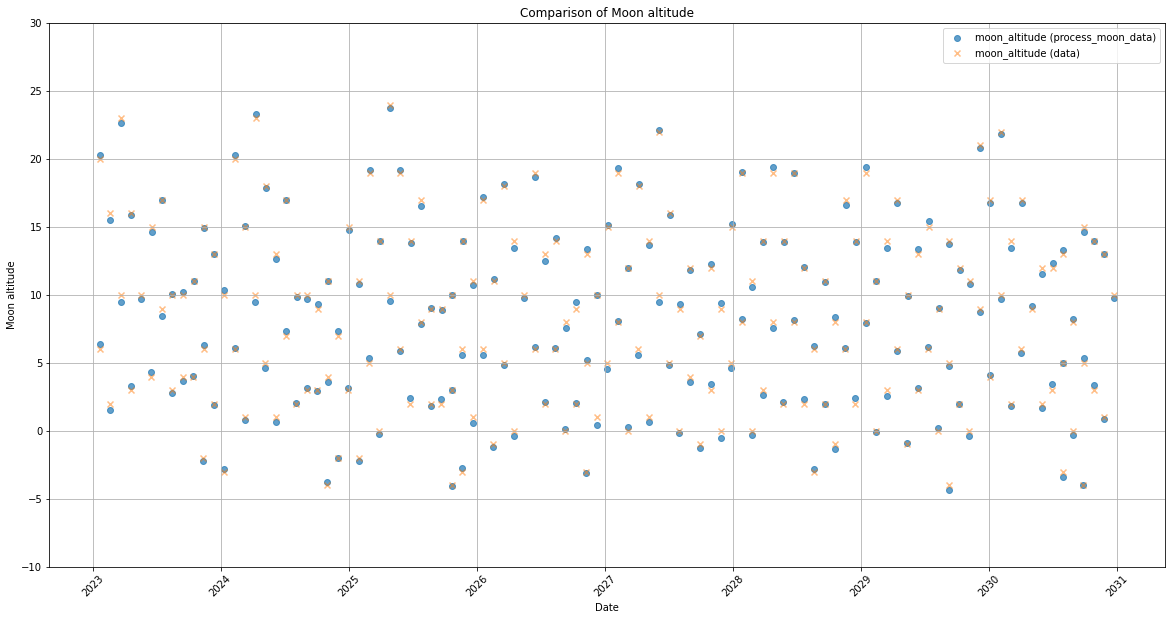

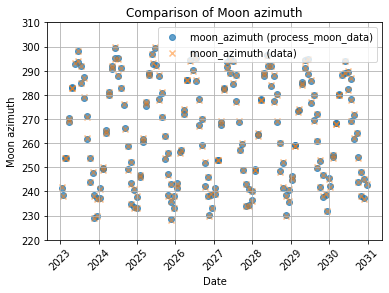

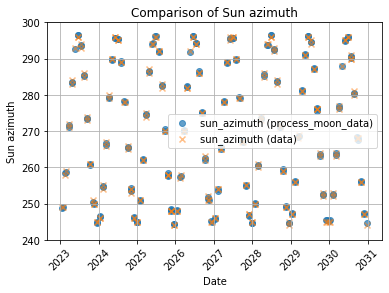

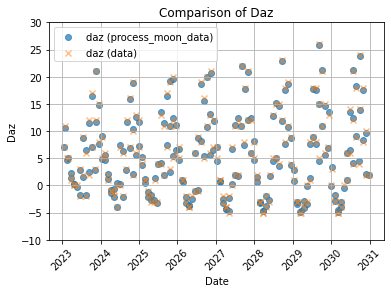

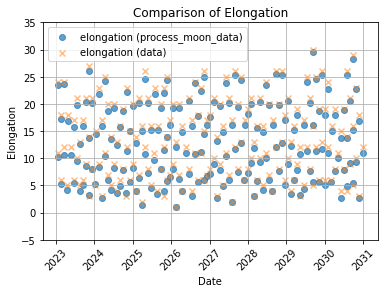

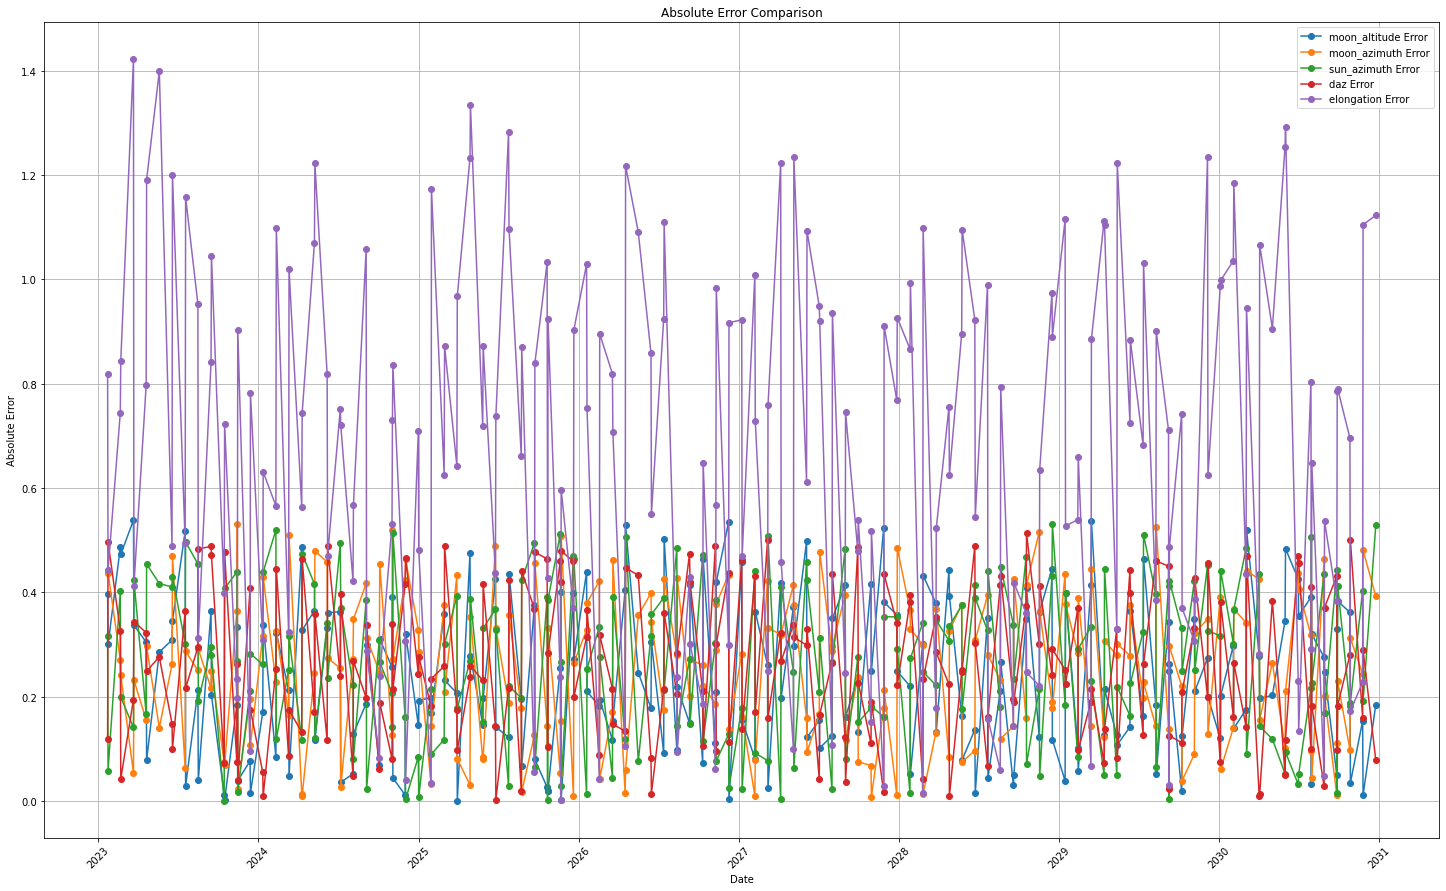

In [28]:
import matplotlib.pyplot as plt

parameters = [
    "moon_altitude",   # Moon's altitude
    "daz",             # Difference in azimuth (DAZ)
    "elongation",      # Moon-Sun elongation   
]

import pandas as pd
import matplotlib.pyplot as plt

def compare_and_plot(df1, df2, parameters):
    """
    Compare two DataFrames and plot scatter plots for common parameters.
    Also, compute absolute and percentage errors for better analysis.

    Parameters:
    df1 - DataFrame from process_moon_data()
    df2 - DataFrame from data()
    parameters - List of column names to compare (must be present in both DataFrames)
    """
    common_params = [param for param in parameters if param in df1.columns and param in df2.columns]

    if not common_params:
        print("No common parameters found for comparison.")
        return
    
    # Convert numeric columns to float, coerce errors to NaN if necessary
    df1[common_params] = df1[common_params].apply(pd.to_numeric, errors='coerce')
    df2[common_params] = df2[common_params].apply(pd.to_numeric, errors='coerce')

    error_df = pd.DataFrame(index=df1.index)  # Create an empty DataFrame to store errors
    
    plt.figure(figsize=(20, 10))
    common_params = common_params[:-2]


    for param in common_params:
        # Compute Absolute and Percentage Error
        error_df[f"{param}_error"] = abs(df1[param] - df2[param])
        error_df[f"{param}_percent_error"] = (error_df[f"{param}_error"] / df1[param]) * 100

        # Scatter plot comparison
        plt.scatter(df1.index, df1[param], label=f"{param} (process_moon_data)", alpha=0.7)
        plt.scatter(df2.index, df2[param], label=f"{param} (data)", alpha=0.5, marker='x')

        plt.xlabel("Date")
        plt.ylabel(param.replace("_", " ").capitalize())
        plt.title(f"Comparison of {param.replace('_', ' ').capitalize()}")

        # Ensure yticks include negative values and are sorted
        yticks = sorted(set(plt.yticks()[0]))  # Extract current yticks, sort them
        plt.yticks(yticks)  
        
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)

        plt.show()
    # --- Plot Absolute Error ---
    plt.figure(figsize=(25, 15))
    for param in common_params:
        plt.plot(error_df.index, error_df[f"{param}_error"], marker='o', linestyle='-', label=f"{param} Error")

    plt.xlabel("Date")
    plt.ylabel("Absolute Error")
    plt.title("Absolute Error Comparison")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

    # --- Save Data to CSV ---
    df1.to_csv('calculated_data.txt', sep=" ", index=True, header=True)
    error_df.to_csv('error_data.txt', sep=" ", index=True, header=True)

    return error_df  # Return the error DataFrame for further analysis if needed

# Example usage:
df1 = process_moon_data(data(), 24.81, 67, elevation=10, pressure=0, horizon='0', epoch='2000')    
parameters = df1.columns.tolist()  # Compare all available columns
error_df = compare_and_plot(df1, data(), parameters)



In [16]:
obs_date = Time(datetime(2025, 2, 28)) 
date = get_sunset_time( 25, 67, obs_date)
moon_params = get_moon_parameters(date, 25, 67, elevation=10, pressure=0, horizon='0', epoch='2000')
visibility_info = calculate_q_and_visibility(moon_params)
print(visibility_info)

{'q_value': -0.56, 'visibility_criterion': 'F'}


In [62]:
version_6
#Example usage
obs_date = Time(datetime(2025, 2, 28))  # 3:30:45 PM UTC
date = get_sunset_time( 25, 67, obs_date)
obs_date = Time(datetime(2025, 2, 28, 13, 34, 45))  # 3:30:45 PM UTC
moon_params = get_moon_parameters(obs_date, 25, 67, elevation=10, pressure=0, horizon='0', epoch='2000')
visibility_info = calculate_q_and_visibility(moon_params)
print(visibility_info)

{'q_value': -0.5573477629491784, 'visibility_criterion': 'F - Not visible, below Danjon limit'}


In [26]:
def calculate_q_and_visibility(moon_params):
    """Calculate q value and determine crescent visibility criteria."""
    arcv = moon_params["arcv"]  # Use altitude difference
    width = moon_params["moon_angular_diameter"] * 60  # Convert to arcseconds
    
    q = (arcv - (11.8371 - 6.3226 * width + 0.7319 * width**2 - 0.1018 * width**3)) / 10
    
    if q > 0.216:
        visibility = "Easily visible to the unaided eye"
    elif 0.216 >= q > -0.014:
        visibility = "Visible under perfect atmospheric conditions"
    elif -0.014 >= q > -0.160:
        visibility = "May need optical aid first"
    elif -0.160 >= q > -0.232:
        visibility = "Can only be seen with binoculars/telescope"
    elif -0.232 >= q > -0.293:
        visibility = "Below normal detection limit"
    else:
        visibility = "Not visible, below Danjon limit"
    
    return {"q_value": q, "visibility_criterion": visibility}

#Example usage
obs_date = Time(datetime(2025, 2, 28, 13, 34, 45))  # 3:30:45 PM UTC
moon_params = get_moon_parameters(obs_date, 25, 67, elevation=10, pressure=0, horizon='0', epoch='2000')
visibility_info = calculate_q_and_visibility(moon_params)
print(visibility_info)

2025/2/28 13:34:45
5:09:41.4
{'q_value': 78610844.97373904, 'visibility_criterion': 'Easily visible to the unaided eye'}
